In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from phase_2.scripts.strategies.trend.trend_strategy_v1 import run_trend_strategy_v1
from phase_2.scripts.strategies.meanrev.meanrev_strategy_v1 import run_meanrev_strategy_v1
from phase_2.scripts.strategies.meta.meta_allocator_v1 import build_regime_features, build_meta_raw_returns
from phase_2.scripts.strategies.meta.risk_targeting_v1 import apply_vol_targeting


In [2]:
ASSETS = ["SPY", "AAPL", "MSFT"]

data = {}
for sym in ASSETS:
    path = f"../data/processed/{sym.lower()}_daily.parquet"
    df = pd.read_parquet(path)
    df["date"] = pd.to_datetime(df["date"])
    df = df.sort_values("date").reset_index(drop=True)
    df["year"] = df["date"].dt.year
    data[sym] = df


In [3]:
def sharpe_ratio(daily_ret: np.ndarray) -> float:
    daily_ret = np.asarray(daily_ret, dtype=float)
    if np.nanstd(daily_ret) == 0:
        return np.nan
    return np.sqrt(252) * np.nanmean(daily_ret) / np.nanstd(daily_ret)

def max_drawdown(equity: np.ndarray) -> float:
    equity = np.asarray(equity, dtype=float)
    peak = np.maximum.accumulate(equity)
    drawdown = equity / peak - 1.0
    return np.nanmin(drawdown)


In [4]:
all_asset_summaries = {}
all_asset_daily = {}

for sym, df in data.items():
    print(f"\nRunning system for {sym}...")
    year_results = []
    daily_all = []

    years = sorted(df["year"].unique())

    for test_year in years:
        train = df[df["year"] < test_year].copy()
        test  = df[df["year"] == test_year].copy()

        if len(train) < 500 or len(test) == 0:
            continue

        # -------------------------------
        # 1. Run strategies
        # -------------------------------
        trend_out = run_trend_strategy_v1(
            test,
            train_df=train,
            prediction_threshold=0.0,
            hold_days=5,
            cost_per_side_bps=5.0,
        )

        meanrev_out = run_meanrev_strategy_v1(
            test,
            entry_ret_5d_threshold=-0.02,
            hold_days=3,
            max_vol_annual=0.40,
            cost_per_side_bps=5.0,
        )

        # -------------------------------
        # 2. Meta allocator
        # -------------------------------
        regime = build_regime_features(test)
        meta = build_meta_raw_returns(trend_out, meanrev_out, regime)

        # -------------------------------
        # 3. Vol targeting
        # -------------------------------
        vt = apply_vol_targeting(
            meta["meta_raw_ret"],
            target_vol_annual=0.10,
            lookback=20,
            max_leverage=1.0,
        )
        meta["meta_ret"] = vt["meta_ret"]
        meta["lev"] = vt["lev"]
        meta["year"] = test_year
        meta["asset"] = sym

        equity = (1 + meta["meta_ret"]).cumprod().values

        state_frac = meta["state"].value_counts(normalize=True).to_dict()

        summary = {
            "asset": sym,
            "year": test_year,
            "sharpe": sharpe_ratio(meta["meta_ret"].values),
            "total_return": equity[-1] - 1.0,
            "max_drawdown": max_drawdown(equity),
            "pct_trend": state_frac.get("TREND", 0.0),
            "pct_meanrev": state_frac.get("MEANREV", 0.0),
            "pct_cash": state_frac.get("CASH", 0.0),
        }

        year_results.append(summary)
        daily_all.append(meta)

    all_asset_summaries[sym] = pd.DataFrame(year_results)
    all_asset_daily[sym] = pd.concat(daily_all).sort_values("date").reset_index(drop=True)



Running system for SPY...

Running system for AAPL...

Running system for MSFT...


In [5]:
for sym, summary in all_asset_summaries.items():
    print(f"\n==== {sym} ====")
    display(summary)



==== SPY ====


,asset,year,sharpe,total_return,max_drawdown,pct_trend,pct_meanrev,pct_cash
0,SPY,2012,0.137596,0.006585,-0.088604,0.336000,0.156000,0.508000
1,SPY,2013,1.746737,0.134284,-0.056151,0.638889,0.063492,0.297619
2,SPY,2014,1.184784,0.082965,-0.038728,0.607143,0.071429,0.321429
3,SPY,2015,0.428145,0.028234,-0.058301,0.369048,0.115079,0.515873
4,SPY,2016,1.378208,0.083083,-0.033794,0.583333,0.023810,0.392857
5,SPY,2017,2.578567,0.142001,-0.020046,0.725100,0.000000,0.274900
6,SPY,2018,-0.604326,-0.049523,-0.111282,0.406375,0.207171,0.386454
7,SPY,2019,1.981796,0.142895,-0.043469,0.555556,0.119048,0.325397
8,SPY,2020,2.680575,0.216650,-0.030493,0.525692,0.055336,0.418972
9,SPY,2021,1.648447,0.134048,-0.045939,0.662698,0.055556,0.281746



==== AAPL ====


,asset,year,sharpe,total_return,max_drawdown,pct_trend,pct_meanrev,pct_cash
0,AAPL,2012,0.545621,0.046551,-0.091234,0.284000,0.224000,0.492000
1,AAPL,2013,1.336634,0.124019,-0.086065,0.412698,0.194444,0.392857
2,AAPL,2014,2.602005,0.254380,-0.050610,0.615079,0.087302,0.297619
3,AAPL,2015,-0.585033,-0.056228,-0.128070,0.273810,0.253968,0.472222
4,AAPL,2016,0.672625,0.055016,-0.083815,0.416667,0.202381,0.380952
5,AAPL,2017,1.631890,0.146066,-0.051342,0.557769,0.163347,0.278884
6,AAPL,2018,0.903063,0.080742,-0.068400,0.438247,0.151394,0.410359
7,AAPL,2019,3.116596,0.319674,-0.058571,0.623016,0.099206,0.277778
8,AAPL,2020,2.796978,0.288034,-0.035621,0.490119,0.007905,0.501976
9,AAPL,2021,2.452571,0.256417,-0.041539,0.507937,0.146825,0.345238



==== MSFT ====


,asset,year,sharpe,total_return,max_drawdown,pct_trend,pct_meanrev,pct_cash
0,MSFT,2012,0.069881,0.002404,-0.052368,0.208000,0.312000,0.480000
1,MSFT,2013,1.118922,0.085181,-0.050647,0.436508,0.075397,0.488095
2,MSFT,2014,1.004737,0.089897,-0.047755,0.619048,0.099206,0.281746
3,MSFT,2015,1.334480,0.117204,-0.074880,0.404762,0.138889,0.456349
4,MSFT,2016,1.258008,0.099633,-0.044602,0.519841,0.115079,0.365079
5,MSFT,2017,2.141689,0.186102,-0.037471,0.701195,0.031873,0.266932
6,MSFT,2018,1.647340,0.155164,-0.060153,0.490040,0.083665,0.426295
7,MSFT,2019,3.476786,0.349719,-0.040057,0.638889,0.043651,0.317460
8,MSFT,2020,2.930259,0.312030,-0.026949,0.533597,0.043478,0.422925
9,MSFT,2021,2.890490,0.293481,-0.032272,0.603175,0.115079,0.281746


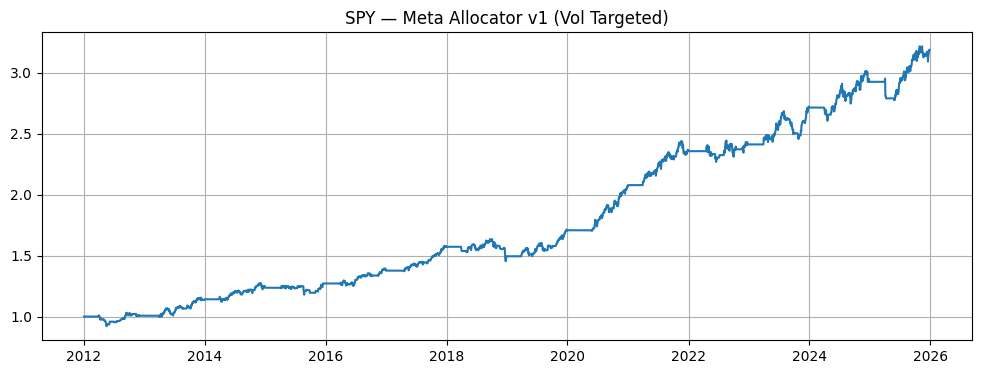

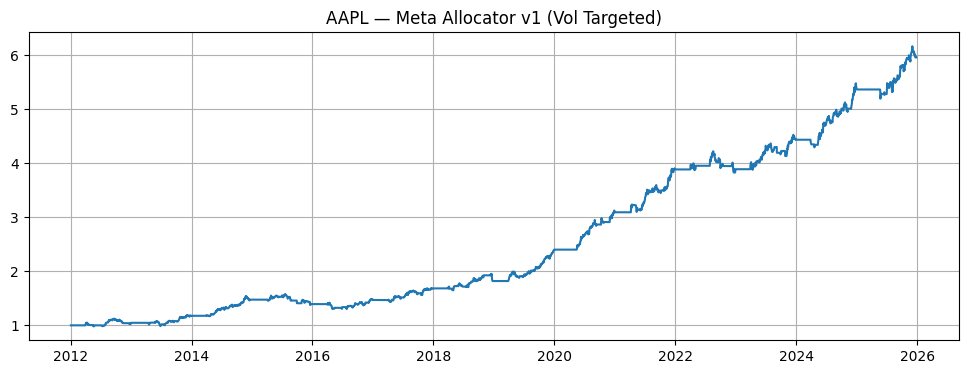

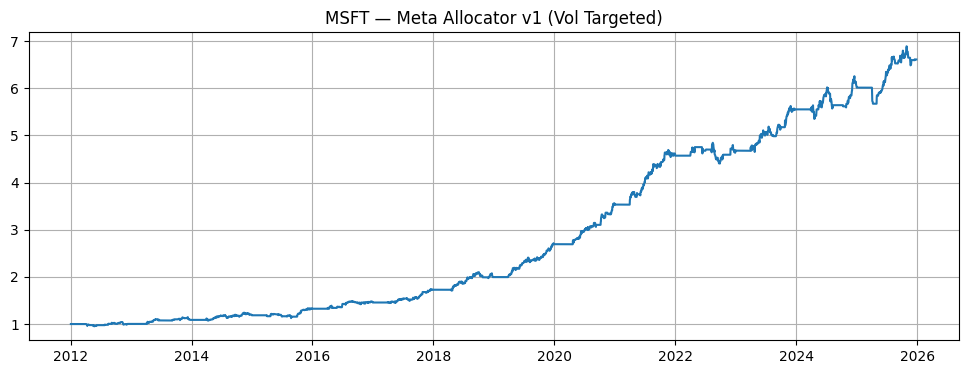

In [6]:
for sym, df in all_asset_daily.items():
    equity = (1 + df["meta_ret"]).cumprod()

    plt.figure(figsize=(12,4))
    plt.plot(df["date"], equity)
    plt.title(f"{sym} — Meta Allocator v1 (Vol Targeted)")
    plt.grid(True)
    plt.show()


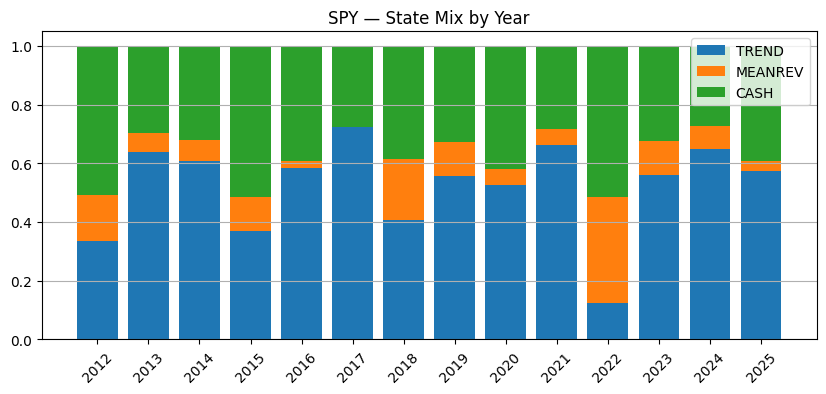

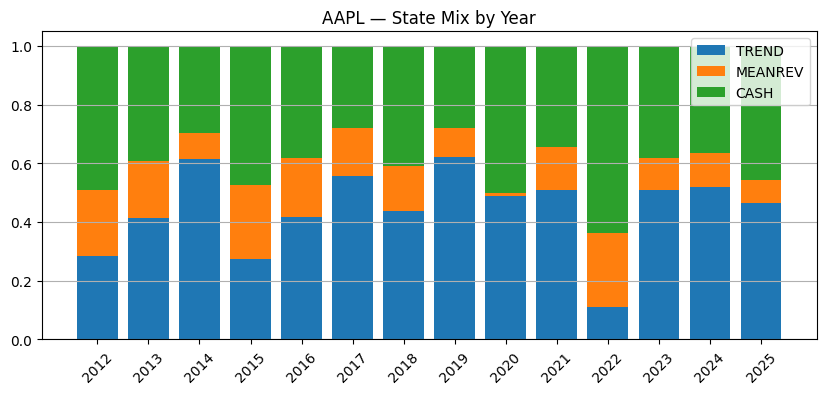

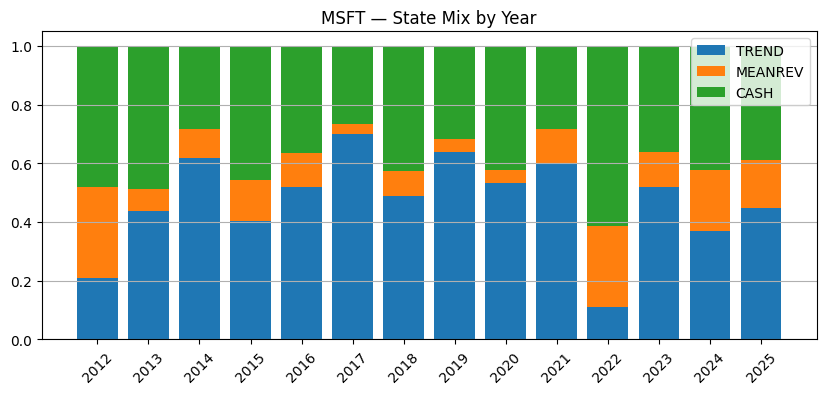

In [7]:
for sym, summary in all_asset_summaries.items():
    years = summary["year"].astype(str)

    plt.figure(figsize=(10,4))
    plt.bar(years, summary["pct_trend"], label="TREND")
    plt.bar(years, summary["pct_meanrev"], bottom=summary["pct_trend"], label="MEANREV")
    plt.bar(
        years,
        summary["pct_cash"],
        bottom=summary["pct_trend"] + summary["pct_meanrev"],
        label="CASH",
    )

    plt.title(f"{sym} — State Mix by Year")
    plt.xticks(rotation=45)
    plt.grid(True, axis="y")
    plt.legend()
    plt.show()
